In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import os
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras.layers import Dense, Input
from keras.models import load_model
import sklearn
import sklearn.preprocessing 
from generate_data import export_virtual_data
from get_data_cal_ut import generate_data_calibration
from protomodels import mises, tresca

In [38]:
current_dir = "./"  # Assuming current directory
dir = "/"
if os.name == "nt":
    current_dir = ".\\"
    dir = "\\"

In [39]:
"----------------------------------------------------------------VARIABLES---------------------------------------------------------------------------------------------"
material = "DP780"
a = 500
b = 140
c = 200

gseed = 6
emod = 70000.
enu = 0.3
density = 7.85e-9
nb_virtual_pt = 20
degree = 4
weigth_exp = 0.9
protomodel = "mises"
gen_v_data = True
gen_e_data = False
adapt = False
export_coeff_abq = False
export_coeff_user = False
plot = True

In [40]:
a1 = 3
a2 = 3
a3 = 3
a4 = 3
a5 = 3
a6 = 3
b1 = 0
b2 = 0
b3 = 0
b4 = 0
b5 = 0
b6 = 0
b7 = 0
b8 = 0
b9 = 1
b10 = 0
b11 = 0
b12 = 0
b13 = 1
b14 = 1
b15 = 0
b16 = 0
b17 = 0
b18 = 0
b19 = 0
b20 = 1
b21 = 1
b22 = 1

In [41]:
"""----------------------------------------------------------------- GENERATING DATA ----------------------------------------------------------------------------------"""
thetas = ["00", "15", "30", "45", "60", "75", "90"]
materials = ["AA7020-T6", "DP600", "DP780"]
if gen_v_data :
    print("Génération du data virtuel en cours")
    if protomodel == "mises":
        export_virtual_data(mises, protomodel, material, nb_virtual_pt)
    if protomodel == "tresca":
        export_virtual_data(tresca, protomodel, material, nb_virtual_pt)
    print("Génération du data virtuel terminé")
if gen_e_data:
    generate_data_calibration(material, thetas)

Génération du data virtuel en cours
0
Génération du data virtuel terminé


In [42]:
""" ----------------------------------------------------------- READ DATA ----------------------------------------------------------------------------------------------"""
def readData(material, protomodel):
    filename_v = "data_virtual_" + material + "_" + protomodel + ".csv"
    filepath_v = current_dir + material + "_results" + dir + "DATA" + dir + filename_v

    db_v = pd.read_csv(filepath_v)

    filename_e = "data_cal_" + material + ".csv"
    filepath_e = current_dir + material + "_results" + dir + "DATA" + dir + filename_e

    db_e = pd.read_csv(filepath_e)

    sigma0 = db_e["YieldStress"].iloc[0]

    db_e["s11"] = db_e["YieldStress"] / sigma0 * (np.square(np.cos(db_e["LoadAngle"])) + db_e["q"] * np.square(np.sin(db_e["LoadAngle"])))
    db_e["s22"] = db_e["YieldStress"] / sigma0 * (np.square(np.sin(db_e["LoadAngle"])) + db_e["q"] * np.square(np.cos(db_e["LoadAngle"])))
    db_e["s33"] = db_e["YieldStress"] * 0
    db_e["s12"] = db_e["YieldStress"] / sigma0 * (1 - db_e["q"]) * np.sin(db_e["LoadAngle"]) * np.cos(db_e["LoadAngle"]) / sigma0
    db_e["s13"] = db_e["YieldStress"] * 0
    db_e["s23"] = db_e["YieldStress"] * 0
    db_e.loc[db_e["Rval"] == "*", "Rval"] = 10

    db = pd.concat([db_e, db_v])

    db["d11"] = (2/3) * db["s11"] - (1/3) * db["s22"] - (1/3) * db["s33"]
    db["d22"] = - (1/3) * db["s11"] + (2/3) * db["s22"] - (1/3) * db["s33"]

    return(db)
db = readData(material, protomodel)
nb_virtual_pt = len(db[db["Type"] == "v"])
data = db[["d11", "d22", "s12", "s13", "s23","LoadAngle", "Rval"]].values

In [ ]:
"""------------------------ MODEL AND SCALER LOADING -------------------------------------------------"""



In [63]:
""" ---------------------------------------------PARAMETERS OPTIMIZATION-----------------------------------------------------------------------------"""
def create_model():
    def custom_activation(x):
        return 0.5 * (1 + tf.math.sign(x)) * (x + 1/100) +  0.5 * (1 - tf.math.sign(x)) * tf.math.exp(tf.math.minimum(0.0,x)) / 100

    model = Sequential([])
    model.add(Input(shape=(22,)))
    model.add(Dense(200, activation=custom_activation))
    model.add(Dense(200, activation=custom_activation))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=["accuracy"])

    return(model)



def optiCoeff(data, degree, weigth_exp):
    polyN = sklearn.preprocessing.PolynomialFeatures((degree, degree), include_bias=False)
    X = polyN.fit_transform(data[:, :5],)
    powers = polyN.powers_
    nmon_abq = len(powers)

    selected_indices = []
    for i in range(nmon_abq):
        k,l,m,n,p = powers[i]
        if ((m==n) and (n==p)) or ((m%2==0) and (n%2==0) and (p%2==0)):
            selected_indices.append(i)

    powers = powers[selected_indices].T
    X = X[:,selected_indices]

    sorted_indices = np.lexsort((powers[1], powers[2], powers[3], powers[4]))
    powers = powers.T[sorted_indices]
    X = X[:,sorted_indices]

    weigth = np.where(db["Type"] == "e", weigth_exp, 1-weigth_exp)
    ndata, nmon = X.shape
    M = np.zeros((nmon, nmon))

    model = create_model()
    model.load_weights("model_0.keras")

    for i in range(ndata):
        Xi = np.expand_dims(X[i], axis=0)
        M = M + weigth[i] * np.dot(Xi.T, Xi)
    M = M / 2

    V = np.sum(np.expand_dims(weigth, axis=1) * X, axis = 0)

    D = np.sum(weigth, axis = 0)

    def J(a):
        return np.dot(np.dot(a, M), a) - np.dot(V, a) + D

    def Grad_J(a):
        return 2 * np.dot(M, a) - V

    a = np.zeros(len(powers))
    a[0] = 1

    print("Optimisation en cours")
    opt = scipy.optimize.minimize(J, a, method='BFGS', jac=Grad_J)
    print("Optimisation terminée")
    coeff = opt.x

    coeff_model = np.atleast_2d(coeff)
    print(model.predict(coeff_model))
    return(coeff, powers, nmon, nmon_abq)

coeff, powers, nmon, nmon_abq = optiCoeff(data, degree, weigth_exp)
print(coeff)

Optimisation en cours
Optimisation terminée
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
[[0.]]
[   0.94023082    6.97173563  -15.99134392    8.91103779    0.82695289
   25.02515934  -28.04553872  -25.50761266    9.46243293   14.55959669
 -172.7153104   159.77415504  -38.62615735   22.49232082  130.25269078
 -183.92550277   10.60521502   55.00973079   11.18036212   23.97881451
   61.74909799   -4.73687212]


c:\Users\cnober\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [51]:
"""----------------------------------------------------FIXING PARAMETERS-----------------------------------------------------------------------------"""

coeff_deg2 = np.array([a1, a2, a3, a4, a5, a6])
coeff_deg4 = np.array([b1, b2, b3, b4, b5, b6, b7, b8, b9, b10, b11, b12, b13, b14, b15, b16, b17, b18, b19, b20, b21, b22])
def adapt_coeff(adapt, degree, coeff):
    if adapt :
        if degree == 2:
            return coeff_deg2
        elif degree == 4:
            return coeff_deg4
    return coeff
coeff = adapt_coeff(adapt, degree, coeff)

print(coeff)

[  26.27862798   28.68633655  -11.02929422   54.18822268   35.87268121
   -1.92995333  118.31023142    4.25333686   10.2044597    -4.58677493
  -62.81019232   30.18904981   19.38584653    8.06985757   30.42751476
   23.10478954  -10.93398416 -105.62100354  -47.87805359   36.40199966
    9.7030355    21.38137562]


In [52]:
""" ---------------------------------------------------POLYN DEFINITION------------------------------------------------------------------------------"""
def dev(S):
    if S.ndim==1:
        S = np.expand_dims(S, axis=0)
    D = S.copy()
    trace_dev = S[:,0] + S[:,1] + S[:,2]
    D[:,0] = S[:,0] - (1/3) * trace_dev
    D[:,1] = S[:,1] - (1/3) * trace_dev
    D[:,2] = S[:,2] - (1/3) * trace_dev
    return(D)

def polyN(S, coeff=coeff):
    if S.ndim==1:
        S = np.expand_dims(S, axis=0)
    D = dev(S)
    X = D[:,[0, 1, 3, 4, 5]]
    res = np.zeros(len(X))
    for i in range(nmon) :
        p = powers[i]
        res = res + coeff[i] * np.prod(X ** p, axis=1)
    return(res)

def polyN_plane(S_plane):
    if S_plane.ndim == 1:
        S_plane = np.expand_dims(S_plane, axis=0)
    S = np.zeros((len(S_plane),6))
    S[:,0] = S_plane[:,0]
    S[:,1] = S_plane[:,1]
    S[:,3] = S_plane[:,2]
    return(polyN(S))

"""----------------------------------------------GRADIENT AND HESSIAN OF POLYN DEFINITION-----------------------------------------------------------"""

def jac_dev(S):
    jac = np.zeros((5, 6))
    jac[0] = np.array([2/3, -1/3, -1/3, 0, 0, 0])
    jac[1] = np.array([-1/3, 2/3, -1/3, 0, 0, 0])
    jac[2] = np.array([0, 0, 0, 1, 0, 0])
    jac[3] = np.array([0, 0, 0, 0, 1, 0])
    jac[4] = np.array([0, 0, 0, 0, 0, 1])
   
    return(jac)

def jac_polyN_param(coeff, powers):
    """
        Compute the different parameters and coefficients to compute the Jacobian of polyN
        Input :
            - coeff (float ndarray of shape (nmon)) : Coefficients of the polyN function
            ordered by power[1] asc, power[2] asc, power[3] asc, power[4] asc
            - powers (float ndarray of shape (nmon, 5)) : Powers for each monomial of the 
            PolyN function
        
        Output :
            - coeff_grad (float ndarray of shape (5, nmon)) : coeff_grad[i] contains the 
            coefficients of each monomial derived with respect to dev[i]¨
            - powers_grad (float ndarray of shape (5, nmon, 5)) : powers_grad[i][j] contains
            the monomial j derived with respect to dev[i]
    """
    coeff_grad = np.zeros((5, coeff.shape[0]))
    powers_grad = np.zeros((5, powers.shape[0], powers.shape[1]))
    for i in range(5):
        coeff_grad[i] = coeff * powers[:,i]
        subs = np.zeros(powers_grad[i].shape)
        subs[:,i] = -1
        powers_grad[i] = np.maximum(0,powers + subs)
    
    return(coeff_grad, powers_grad)

coeff_grad, powers_grad = jac_polyN_param(coeff, powers)

def grad_polyN(S, coeff_grad=coeff_grad, powers_grad=powers_grad):
    """
        Input :
            - S (float ndarray of shape : len(data) * 6) : Stress
            - coeff_grad : coeff_grad (float ndarray of shape (5, nmon)) : coeff_grad[i] contains the 
            coefficients of each monomial derived with respect to dev[i]¨
            - powers_grad (float ndarray of shape (5, nmon, 5)) : powers_grad[i][j] contains
            the monomial j derived with respect to dev[i]
    """
    if S.ndim==1:
        S = np.expand_dims(S, axis=0)
    D = dev(S)
    X = D[:,[0, 1, 3, 4, 5]]

    grad_polyN = np.zeros(6)
    grad_f = np.zeros((len(X),5))

    for i in range(5):
        for j in range(nmon):
            p = powers_grad[i][j]
            grad_f[:,i] = grad_f[:,i] + coeff_grad[i][j] * np.prod(X ** p, axis=1)
    
    jac_d = jac_dev(S)

    grad_polyN = np.dot(grad_f, jac_d)
    return(grad_polyN)

def hessian_polyN_param(coeff_grad, powers_grad):
    """
    Compute the different parameters and coefficients to compute the Hessian of polyN
        Input :
            - coeff_grad (float ndarray of shape (5, nmon)) : coeff_grad[i] contains the 
            coefficients of each monomial derived with respect to dev[i]
            - powers_grad (float ndarray of shape (5, nmon, 5)) : powers_grad[i][j] contains
            the powers of the monomial j derived with respect to dev[i]
        
        Output :
            - coeff_hessian (float ndarray of shape (5, 5, nmon)) : coeff_hessian[i][j][k] contains
            the coefficients of the monomial k of polyN derived with respect to dev[i] and then to dev[j]
            - powers_hessian (float ndarray of shape (5, 5, nmon, 5)) : powers_hessian[i][j][k] contains
            the powers of the monomial k of polyN derived with respect to dev[i] and then to dev[j]

    """
    coeff_hessian = np.zeros((5, coeff_grad.shape[0], coeff_grad.shape[1]))
    powers_hessian = np.zeros((5, powers_grad.shape[0], powers_grad.shape[1], powers_grad.shape[2]))

    for i in range(5):
        for j in range(5):
            coeff_hessian[i][j] = coeff_grad[i] * powers_grad[i,:,j]
            subs = np.zeros(powers_hessian[i][j].shape)
            subs[:,j] = -1
            powers_hessian[i][j] = np.maximum(0,powers_grad[i] + subs)
    
    return(coeff_hessian, powers_hessian)

coeff_hessian, powers_hessian = hessian_polyN_param(coeff_grad, powers_grad)

def hessian_polyN(S, coeff_hessian=coeff_hessian, powers_hessian=powers_hessian):
    if S.ndim==1:
        S = np.expand_dims(S, axis=0)
    D = dev(S)
    X = D[:,[0, 1, 3, 4, 5]]

    hessian_polyN = np.zeros((6,6))
    jac_grad_f = np.zeros((len(X), 5, 5))

    for i in range(5):
        for j in range(5):
            for k in range(nmon):
                p = powers_hessian[i][j][k]
                jac_grad_f[:,i,j] = jac_grad_f[:,i,j] + coeff_hessian[i][j][k] * np.prod(X ** p, axis=1)
    
    jac_d = jac_dev(S)
    hessian_polyN = np.transpose(np.dot(jac_d.T,np.dot(jac_grad_f[:], jac_d)), (1, 2, 0))
    return(hessian_polyN)

In [53]:
"""----------------------------------------------------TESTING FUNCTIONS (PLOT & CONVEXITY)-----------------------------------------------------------------"""
## WRAP FUNCTION BEFORE USING PLOT IMPLICIT
def plot_implicit(yf, bbox=(-1.5,1.5)):
    ''' create a plot of an implicit function
    fn  ...implicit function (plot where fn==0)
    bbox ..the x,y,and z limits of plotted interval'''
    xmin, xmax, ymin, ymax, zmin, zmax = bbox*3
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    A = np.linspace(xmin, xmax, 50) # resolution of the contour
    B = np.linspace(xmin, xmax, 10) # number of slices
    A1,A2 = np.meshgrid(A,A) # grid on which the contour is plotted

    print("Début du plot sur XY")
    for z in B: # plot contours in the XY plane
        X,Y = A1,A2
        Z = yf(X,Y,z) - 1
        cset = ax.contour(X, Y, Z+z, [z], zdir='z')
        # [z] defines the only level to plot for this contour for this value of z
    print("Fin du plot sur XY")
    print("Début du plot sur XZ")
    for y in B: # plot contours in the XZ plane
        X,Z = A1,A2
        Y = yf(X,y,Z) - 1
        cset = ax.contour(X, Y+y, Z, [y], zdir='y')

    print("Fin du plot sur XZ")
    print("Début du plot sur YZ")
    for x in B: # plot contours in the YZ plane
        Y,Z = A1,A2
        X = yf(x,Y,Z) - 1
        cset = ax.contour(X+x, Y, Z, [x], zdir='x')
    print("Fin du plot sur YZ")
    # must set plot limits because the contour will likely extend
    # way beyond the displayed level.  Otherwise matplotlib extends the plot limits
    # to encompass all values in the contour.
    ax.set_zlim3d(zmin,zmax)
    ax.set_xlim3d(xmin,xmax)
    ax.set_ylim3d(ymin,ymax)

    plt.show()

Début du plot sur XY
Fin du plot sur XY
Début du plot sur XZ
Fin du plot sur XZ
Début du plot sur YZ
Fin du plot sur YZ


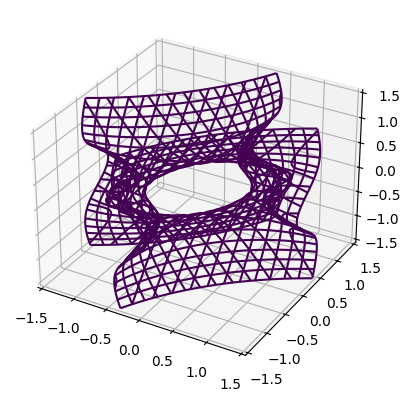

In [55]:
"""---------------------------------------------------------------------TESTING-----------------------------------------------------------------------------------------"""
data = db[["s11", "s22", "s33", "s12", "s13", "s23"]].values
S0 = np.zeros(6)

S1 = np.zeros(6)
S1[0] = 1

S1_plane = np.zeros(3)
S1_plane[0] = 1

lS = np.array([S0, S1, S1])

B = hessian_polyN(S1)

S2 = np.zeros(6)
S2[0] = 1
S2[1] = 1

S3 = np.zeros(6)
S3[5] = 1

S4 = np.zeros(6)
S4[4] = 1
S4[5] = 1

S5 = np.zeros(6)
S5[3] = 1
S5[4] = 1
S5[5] = 1

A = np.zeros((6,6))
A[0, 0] = 2
A[1,1] = 2
A[0, 1] = -1
A[1, 0] = -1
A[2,2] = 2
A[0,2] = -1
A[1, 2] = -1
A[2,0] = -1
A[2, 1] = -1
A[3,3] = 6
A[4,4] = 6
A[5,5] = 6


if plot:
    polyN_plane_wrap = np.vectorize(lambda x, y, z : polyN(np.array([x, y, 0, z, 0, 0])))
    plot_implicit(polyN_plane_wrap)

In [ ]:
"""-------------------------------------------------OUTPUT---------------------------------------------------------------------------------------------"""
def write_coeff_user(coeff, protomodel, degree, material, nb_virtual_pt):
    filename = "{}_deg{}_{}.txt".format(material, degree, protomodel)
    foldername = current_dir + material + "_results" + dir + "COEFF" + dir
    filepath = foldername + filename

    n = len(coeff)
    with open(filepath, "w") as file:
        file.write("#Coefficients poly{} for {} based on {} points from the {} protomodel\n".format(degree, material, nb_virtual_pt, protomodel))
        file.write("Number of coefficients : {}\n".format(n))
        for i in range(n):
            file.write("{} : {}\n".format(i + 1, coeff[i]))
def write_coeff_abq(coeff, protomodel, degree, material):
    filename = "{}_abq_deg{}_{}.inp".format(material, degree, protomodel)
    foldername = current_dir + material + "_results" + dir + "COEFF" + dir
    filepath = foldername + filename

    n = len(coeff)
    with open(filepath, "w") as file:
        file.write("*USER MATERIAL, constants={}\n".format(7 + nmon_abq))
        file.write("{}, {}, {}, {}, {}, {}, {}, ".format(emod, enu, a, b, c, degree, nmon_abq))
        n0 = 0
        n0_abq = 0
        while n0_abq < nmon :
            for m in range(0, degree + 1):
                for l in range(0, degree + 1 - m):
                    for k in range(0, degree + 1 - m - l):
                        for j in range(0, degree + 1 - m - l - k):
                            i = degree - m - l - k - j
                            i0, j0, k0, l0, m0 = powers[n0]
                            if (i==i0) and (j==j0) and (k==k0) and (l==l0) and (m==m0):
                                file.write("{}, ".format(coeff[n0]))
                                n0 = n0 + 1
                            else:
                                file.write("0, ")
                            n0_abq = n0_abq + 1
                            if (n0_abq + 7) % 8 == 0:
                                file.write("\n")
                            
        file.write("\n")
        file.write("*DENSITY\n")
        file.write("{}".format(density))


In [ ]:
if export_coeff_user:
    write_coeff_user(coeff, protomodel, degree, material, nb_virtual_pt)
if export_coeff_abq:
    write_coeff_abq(coeff, protomodel, degree, material)